In [1]:
using Convex
using SCS
using PyPlot
using Distributions

srand(123);

In [2]:
function cloud!(x, res, start, n, d)
    dim = size(x, 2)
    for i=1:n
        res[start+i, 1] = x[1] + rand(d)
        res[start+i, 2] = x[2] + rand(d)
    end
end

function circle!(x, r, res, start, n, d)
    dim = size(x, 2)
    for i=1:n
        angle = rand() * 2 * pi
        res[start+i, 1] = x[1] + cos(angle) * r + rand(d)
        res[start+i, 2] = x[2] + sin(angle) * r + rand(d)
    end    
end

circle! (generic function with 1 method)

In [3]:
function lin_sep_two_clouds()
    x = zeros(100, 2)
    cloud!([0 0], x,  0, 50, Normal(0, 0.2))
    cloud!([1 1], x, 50, 50, Normal(0, 0.2))

    y = repeat([1; -1], inner=50)
    x, y    
end
    
function two_cocentric()
    x = zeros(150, 2)
    cloud!( [0 0],      x,  0,  50, Normal(0, 0.1))
    circle!([0 0], 1.5, x, 50, 100, Normal(0, 0.1))

    y = repeat([1; -1; -1], inner=50)
    x, y
end

function three_cocentric()
    x = zeros(210, 2)
    cloud!( [0 0],      x,   0, 70, Normal(0, 0.2))
    circle!([0 0], 1.5, x,  70, 70, Normal(0, 0.2))
    circle!([0 0], 3, x,   140, 70, Normal(0, 0.2))

    y = repeat([1; -1; 1], inner=70)
    x, y
end

function three_clouds()
    x = zeros(150, 2)
    cloud!([0 0], x,   0, 50, Normal(0, 0.2))
    cloud!([1 1], x,  50, 50, Normal(0, 0.2))
    cloud!([1.5 1], x, 100, 50, Normal(0, 0.2))

    y = repeat([1; 1; -1], inner=50)
    x, y
end

three_clouds (generic function with 1 method)

In [7]:
type SVM
    α::SparseVector{Number, Int64}
    support_vectors_data::Array{Number, 2}
    support_vectors_labels::Array{Number, 1}
    b::Number
    K::Function
end

In [4]:
function make_grammian(K, x, y)
    N = size(x, 1)
    Q = zeros(N, N)
    
    for i=1:N
        for j=1:i
            Q[i, j] = K(x[i, :], x[j, :]) * y[i] * y[j]
            Q[j, i] = Q[i, j]
        end
    end
    
    min_ev = eigmin(Q)
    if min_ev < 0
        Q - 2*min_ev .* I
    else
        Q
    end
end

function train_svm(data, labels; K=vecdot, tol=eps()) :: SVM
    N = size(data, 1)
    
    Q = make_grammian(K, data, labels)
    
    # compute α
    α = Variable(N, 1)
    
    problem = minimize(0.5*quadform(α, Q) - vecdot(α, ones(N)))
    problem.constraints += α >= 0
    problem.constraints += vecdot(α, labels) == 0

    solve!(problem, SCSSolver(verbose=false))
    α = α.value[:, 1]
    α[α .<= tol] = 0
    α = sparse(α)
    
    # compute w
    w = zeros(size(data, 2))
    for i = 1:N
        if α[i] > 0
            w += α[i] * labels[i] * data[i, :]
        end
    end
    
    # compute b
    b = 0
    for i = 1:N
        if α[i] > 0
            b = labels[i] - K(data[i, :], w)
            break
        end
    end
    
    SVM(α, data[α .!= 0, :], labels[α .!= 0], b, K)
end

train_svm (generic function with 1 method)

In [8]:
function svm_predict(svm :: SVM, x)
    f = svm.b
    j = 1
    for i = 1:length(svm.α)
        if svm.α[i] > 0
            f += svm.support_vectors_labels[j] * svm.α[i] * svm.K(x, svm.support_vectors_data[j, :])
            j += 1
        end
    end
    
    f
end

function svm_confusion(svm :: SVM, data, labels)
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i=1:length(labels)
        p = svm_predict(svm, data[i, :]) > 0 ? 1 : -1
        
        if p == -1 && labels[i] == -1
            tn += 1
        elseif p == 1 && labels[i] == -1
            fp += 1
        elseif p == -1 && labels[i] == 1
            fn += 1
        else
            tp += 1
        end
    end
    
    [tn fp; fn tp]
end

svm_confusion (generic function with 1 method)

In [9]:
function svm_show_contour(svm :: SVM, xrange, yrange)
    N = length(xrange)
    
    f(x) = svm_predict(svm, x)
    
    xgrid = repmat(xrange', N, 1 )
    ygrid = repmat(yrange, 1, N)
    
    z = zeros(N,N)

    for i in 1:N
        for j in 1:N
            z[i:i,j:j] = f([xrange[i], yrange[j]])
        end
    end
    
    zgrid = reshape(z, N, N)

    cs = contour(xgrid, ygrid, zgrid)
    clabel(cs, inline=1, fontsize=10)
    grid();
end

svm_show_contour (generic function with 1 method)

 in issym(::Array{Float64,2}, ::Vararg{Array{Float64,2},N}) at ./deprecated.jl:30
 in quadform(::Convex.Variable, ::Array{Float64,2}) at /home/mbulte/.julia/v0.5/Convex/src/atoms/second_order_cone/quadform.jl:11
 in #train_svm#1(::Base.LinAlg.#vecdot, ::Float64, ::Function, ::Array{Float64,2}, ::Array{Int64,1}) at ./In[4]:28
 in (::#kw##train_svm)(::Array{Any,1}, ::#train_svm, ::Array{Float64,2}, ::Array{Int64,1}) at ./<missing>:0
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/mbulte/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /home/mbulte/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[10], in expression starting on line 3


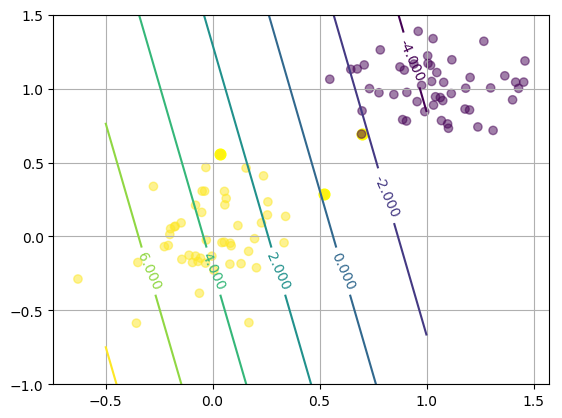

svm_confusion(svm₀,x₀,y₀) = [50 0; 0 50]


In [10]:
x₀, y₀ = lin_sep_two_clouds()

svm₀ = train_svm(x₀, y₀, tol=10.0e-6)
@show svm_confusion(svm₀, x₀, y₀)

svm_show_contour(svm₀, linspace(-0.5, 1.0, 50), linspace(-1.0, 1.5, 50))
scatter(x₀[:, 1][svm₀.α .!= 0], x₀[:, 2][svm₀.α .!= 0], c="yellow", s=60)
scatter(x₀[:, 1], x₀[:, 2], c=y₀, alpha=0.5);

 in issym(::Array{Float64,2}, ::Vararg{Array{Float64,2},N}) at ./deprecated.jl:30
 in quadform(::Convex.Variable, ::Array{Float64,2}) at /home/mbulte/.julia/v0.5/Convex/src/atoms/second_order_cone/quadform.jl:11
 in #train_svm#1(::#poly, ::Float64, ::Function, ::Array{Float64,2}, ::Array{Int64,1}) at ./In[5]:28
 in (::#kw##train_svm)(::Array{Any,1}, ::#train_svm, ::Array{Float64,2}, ::Array{Int64,1}) at ./<missing>:0
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/mbulte/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /home/mbulte/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[8], in expression starting on line 4


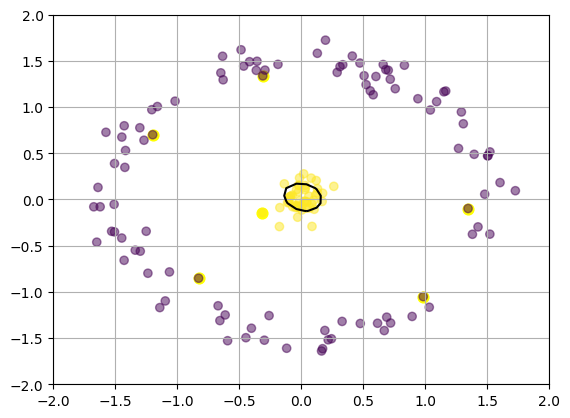

In [8]:
x₁, y₁ = two_cocentric()
poly(l, r) = (1 + vecdot(l, r))^2

svm₁ = train_svm(x₁, y₁, tol=10.0e-10, K=poly)
@show svm_confusion(svm₁, x₁, y₁)

svm_show_contour(svm₁, linspace(-2.0, 2.0, 50), linspace(-2.0, 2.0, 50))
scatter(x₁[:, 1][svm₁.α .!= 0], x₁[:, 2][svm₁.α .!= 0], c="yellow", s=60)
scatter(x₁[:, 1], x₁[:, 2], c=y₁, alpha=0.5);

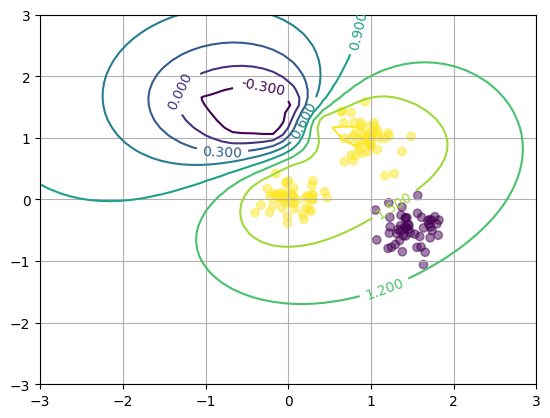

svm_confusion(svm₂,x₂,y₂) = [50 0; 0 100]


In [23]:
x₂, y₂ = three_clouds()
rbf(l, r) = exp(-norm(l - r))

svm₂ = train_svm(x₂, y₂, tol=10.0e-6, K=rbf)
@show svm_confusion(svm₂, x₂, y₂)

svm_show_contour(svm₂, linspace(-3.0, 3.0, 50), linspace(-3.0, 3.0, 50))
scatter(x₂[:, 1], x₂[:, 2], c=y₂, alpha=0.5);